In [ ]:
#================================================
#DEBUG TOGGLE SWITCH

def d(*args, **kwargs):
    if d.ON:
        print(*args, **kwargs)

d.ON = False          # <- module-local switch

##example usage
#d("Initial x shape:", x.shape)
#================================================

try:
    import segmentation_models_pytorch as smp
except ImportError:
    !pip install -q segmentation_models_pytorch timm tensorboard
    import segmentation_models_pytorch as smp

#=======================================================



#=======================================================================
#moving into the folder in order to make sure the system sees the files i need
import sys
sys.path.append("/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/ProjectWorkspace/src")


#=======================================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import random
import numpy as np
from network.deeplab_dualhead import get_model
from network.losses import get_loss
from dataloader.cityscapes_dataloader import CityscapesDataset
#================================================================================================================



#===============================================================================================================
#seed setting
def seed_everything(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

seed_everything(42)
#==================================================================================


#=======================================================================================
#PATHS SETTING
train_images_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/train"
val_images_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/leftImg8bit_trainvaltest/leftImg8bit/val"
train_masks_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/train"
val_masks_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/Datasets/leftImg8bit_trainvaltest/gtFine_trainvaltest/gtFine/val"
split_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/ProjectWorkspace/splits"
log_dir = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/ProjectWorkspace/runs/updated_loss_run"
save_path = "/content/drive/MyDrive/MAGISTRALE/ANNO 1/Computer Vision/Project/RoadObstacleDetection/ProjectWorkspace/ckpts"
os.makedirs(log_dir, exist_ok=True)
os.makedirs(save_path, exist_ok=True)
#========================================================================================================================================================================================


#==========================================================
# SPLITS LOADING
def load_split(file_name):
  with open(os.path.join(split_dir, file_name), "r") as f:
    return [line.strip() for line in f]

train_list = load_split("train_list.txt")
val_list = load_split("val_early.txt")
#===============================================================



#==================================================================
# DATASET LOADING
train_dataset = CityscapesDataset(train_images_dir, train_masks_dir, train_list, augment=True)
val_dataset = CityscapesDataset(val_images_dir, val_masks_dir, val_list, augment=False)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)
#======================================================================================



#===============================================================================================
# SETTIN UP THE MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model().to(device)
criterion = get_loss(lambda_bce=3.0)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


# LR SCHEDULER (poly decay as Noguchi's paper)
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
  new_lr = init_lr * (1 - iter / max_iter) **power
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr
  return new_lr
#=================================================================================================


#=================================================================================================
# TENSORBOARD LOGS
writer = SummaryWriter(log_dir=log_dir)
#=================================================================================================


#==================================================================================
# NOW TRAINING LOOP
#extracted the following as local variables to manage partial train loops and avoid wasting Colab Pro while still checking if everything runs fine
num_epochs = 31
max_iters = 1488 * num_epochs
val_interval = 1488
log_interval = 100

global_step = 0
best_mIoU = 0.0



def compute_mIoU(preds, labels, num_classes=7):
  ious = []
  for cls in range(num_classes):
    pred_inds = preds == cls
    label_inds = labels == cls
    intersection = (pred_inds & label_inds).sum().item()
    union = (pred_inds | label_inds).sum().item()
    if union == 0:
      continue
    ious.append(intersection / union)
  return np.mean(ious) if ious else 0.0








for epoch in range(num_epochs): #it will exit the same when max_iters is reached
  model.train()
  pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

  for images, labels, objects in pbar:
    images, labels, objects = images.to(device), labels.to(device), objects.unsqueeze(1).to(device) #EDIT: added unsqueezing after loss update

    pred_softmax, pred_sigmoid = model(images)
    pred_softmax = F.interpolate(pred_softmax, size=labels.shape[1:], mode='bilinear', align_corners=False)
    pred_sigmoid = F.interpolate(pred_sigmoid, size=labels.shape[1:], mode='bilinear', align_corners=False)

    loss = criterion(pred_softmax, pred_sigmoid, labels, objects)
    if torch.isnan(loss): #now wanna make sure training stops immediately if loss explodes
      print(f"[ERROR] NaN loss at iteration {global_step}. EXITING")
      exit(1)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    if(global_step + 1) % 4 == 0:
      optimizer.step()
      optimizer.zero_grad()

    poly_lr_scheduler(optimizer, 0.01, global_step, max_iters)

    if global_step % log_interval == 0:
      writer.add_scalar("train/loss", loss.item(), global_step)

    pbar.set_postfix(loss=loss.item())

    if global_step % val_interval == 0:
      model.eval()
      with torch.no_grad():
        iou_total = 0.0
        for val_images, val_labels, _ in val_loader:
          val_images = val_images.to(device)
          val_labels = val_labels.to(device)

          pred_softmax, _ = model(val_images) #underscore to ignore 2nd returned thing, cause model returns two things, but now we care only about softmax head's output
          pred_softmax_up = F.interpolate(pred_softmax, size=val_labels.shape[-2:], mode="bilinear", align_corners=False)  #EDIT (following an error): DLV3+ with RN-50 as backbone reduced output resolution, so we gotrta upsample the logits
          preds = torch.argmax(pred_softmax_up, dim=1)

          batch_iou = compute_mIoU(preds, val_labels)
          #iou = (preds == val_labels).float().mean().item()  #WATCH OUT! MOMENTANEOUSLY THIS IS JUST A MEAN ABOUT PIXEL ACCURACY!!!!
          iou_total += batch_iou

        avg_iou = iou_total / len(val_loader)
        writer.add_scalar("val/mIou", avg_iou, global_step)
        print(f"[VAL at EPOCH: {epoch-1}] Avg mIoU = {avg_iou:.4f}")

        if avg_iou > best_mIoU:
          best_mIoU = avg_iou
          torch.save(model.state_dict(), os.path.join(save_path, "updated_loss_model.pth"))

    global_step += 1

  pbar.close()

  if global_step >= max_iters:
    break

print("Full training complete. Best mIoU = ", best_mIoU)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/1487 [00:11<?, ?it/s, loss=4.59]

[VAL at EPOCH: -1] Avg mIoU = 0.0324


Epoch 2:   0%|          | 1/1487 [00:00<14:30,  1.71it/s, loss=3.4] 

[VAL at EPOCH: 0] Avg mIoU = 0.3895


Epoch 3:   0%|          | 1/1487 [00:01<14:55,  1.66it/s, loss=3.32]

[VAL at EPOCH: 1] Avg mIoU = 0.4540


Epoch 4:   0%|          | 3/1487 [00:01<07:41,  3.22it/s, loss=3.2] 

[VAL at EPOCH: 2] Avg mIoU = 0.5051


Epoch 5:   0%|          | 3/1487 [00:01<07:34,  3.26it/s, loss=3.18]

[VAL at EPOCH: 3] Avg mIoU = 0.5701


Epoch 6:   0%|          | 5/1487 [00:01<06:20,  3.89it/s, loss=2.96]

[VAL at EPOCH: 4] Avg mIoU = 0.5855


Epoch 7:   0%|          | 5/1487 [00:01<06:19,  3.91it/s, loss=2.89]

[VAL at EPOCH: 5] Avg mIoU = 0.5907


Epoch 8:   0%|          | 7/1487 [00:01<05:47,  4.26it/s, loss=2.82]

[VAL at EPOCH: 6] Avg mIoU = 0.6072


Epoch 9:   0%|          | 7/1487 [00:02<05:54,  4.18it/s, loss=2.64]

[VAL at EPOCH: 7] Avg mIoU = 0.6133


Epoch 10:   1%|          | 12/1487 [00:44<2:20:24,  5.71s/it, loss=2.16]

[VAL at EPOCH: 8] Avg mIoU = 0.5992


Epoch 11:   1%|          | 13/1487 [00:44<2:04:09,  5.05s/it, loss=2.06]

[VAL at EPOCH: 9] Avg mIoU = 0.6008


Epoch 12:   1%|          | 14/1487 [00:45<2:15:43,  5.53s/it, loss=1.99]

[VAL at EPOCH: 10] Avg mIoU = 0.6025


Epoch 13:   1%|          | 11/1487 [00:03<05:31,  4.46it/s, loss=2.5] 

[VAL at EPOCH: 11] Avg mIoU = 0.6240


Epoch 14:   1%|          | 16/1487 [00:45<2:12:56,  5.42s/it, loss=2.18]

[VAL at EPOCH: 12] Avg mIoU = 0.6146


Epoch 15:   1%|          | 13/1487 [00:03<05:31,  4.44it/s, loss=2.41]

[VAL at EPOCH: 13] Avg mIoU = 0.6372


Epoch 16:   1%|          | 18/1487 [00:45<2:09:36,  5.29s/it, loss=1.94]

[VAL at EPOCH: 14] Avg mIoU = 0.6177


Epoch 17:   1%|▏         | 19/1487 [00:46<1:56:33,  4.76s/it, loss=2.21]

[VAL at EPOCH: 15] Avg mIoU = 0.6250


Epoch 18:   1%|▏         | 20/1487 [00:46<2:07:41,  5.22s/it, loss=2.13]

[VAL at EPOCH: 16] Avg mIoU = 0.6329


Epoch 19:   1%|▏         | 21/1487 [00:46<1:54:41,  4.69s/it, loss=1.97]

[VAL at EPOCH: 17] Avg mIoU = 0.6127


Epoch 20:   1%|▏         | 22/1487 [00:46<2:05:59,  5.16s/it, loss=2.08]

[VAL at EPOCH: 18] Avg mIoU = 0.6112


Epoch 21:   2%|▏         | 23/1487 [00:46<1:53:26,  4.65s/it, loss=2.21]

[VAL at EPOCH: 19] Avg mIoU = 0.6247


Epoch 22:   2%|▏         | 24/1487 [00:47<2:06:01,  5.17s/it, loss=2.51]

[VAL at EPOCH: 20] Avg mIoU = 0.6183


Epoch 23:   2%|▏         | 25/1487 [00:47<1:52:58,  4.64s/it, loss=1.87]

[VAL at EPOCH: 21] Avg mIoU = 0.6255


Epoch 24:   2%|▏         | 26/1487 [00:47<2:05:19,  5.15s/it, loss=1.99]

[VAL at EPOCH: 22] Avg mIoU = 0.6187


Epoch 25:   2%|▏         | 27/1487 [00:48<1:53:16,  4.66s/it, loss=2.15]

[VAL at EPOCH: 23] Avg mIoU = 0.6198


Epoch 26:   2%|▏         | 28/1487 [00:48<2:04:35,  5.12s/it, loss=1.99]

[VAL at EPOCH: 24] Avg mIoU = 0.6161


Epoch 27:   2%|▏         | 29/1487 [00:49<1:55:30,  4.75s/it, loss=1.87]

[VAL at EPOCH: 25] Avg mIoU = 0.6220


Epoch 28:   2%|▏         | 30/1487 [00:48<2:04:48,  5.14s/it, loss=2.11]

[VAL at EPOCH: 26] Avg mIoU = 0.6080


Epoch 29:   2%|▏         | 31/1487 [00:49<1:52:46,  4.65s/it, loss=1.75]

[VAL at EPOCH: 27] Avg mIoU = 0.6328


Epoch 30:   2%|▏         | 32/1487 [00:49<2:43:39,  6.75s/it, loss=2.09]

[VAL at EPOCH: 28] Avg mIoU = 0.6095


Epoch 31:   2%|▏         | 33/1487 [00:49<1:52:04,  4.62s/it, loss=2.22]

[VAL at EPOCH: 29] Avg mIoU = 0.6168


Epoch 31: 100%|██████████| 1487/1487 [05:54<00:00,  4.19it/s, loss=1.93]

Full training complete. Best mIoU =  0.6372046720305535


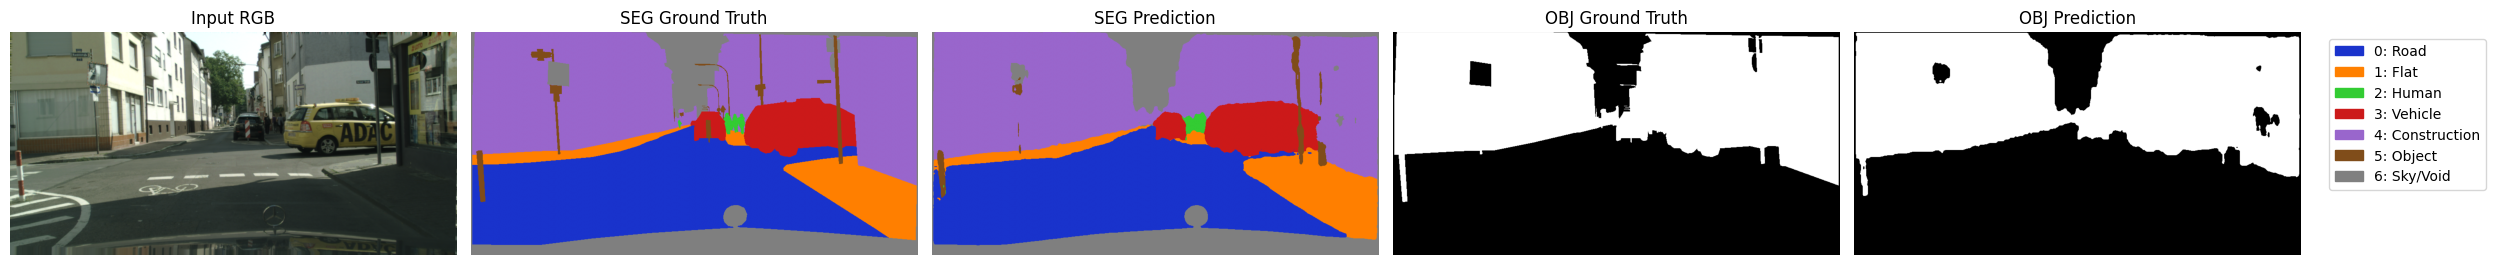

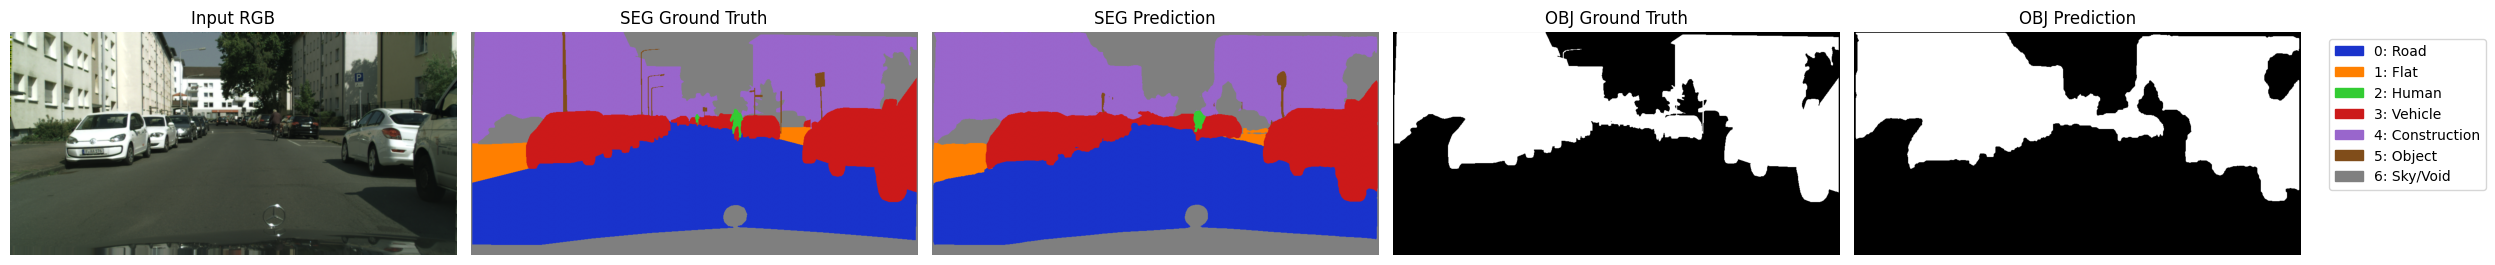

In [ ]:
#===============================================================
# RGB + GT + PRED VISUALIZATION AFTER TRAINING

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.transforms.functional import to_pil_image
from matplotlib.colors import ListedColormap

model.eval()
with torch.no_grad():
    val_images, val_labels, val_objects = next(iter(val_loader))  # one batch
    val_images = val_images.to(device)
    val_labels = val_labels.to(device)
    val_objects = val_objects.to(device)

    pred_softmax, pred_sigmoid = model(val_images)
    pred_softmax_up = F.interpolate(pred_softmax, size=val_labels.shape[-2:], mode="bilinear", align_corners=False)
    pred_sigmoid_up = F.interpolate(pred_sigmoid, size=val_labels.shape[-2:], mode="bilinear", align_corners=False)

    pred_labels = torch.argmax(pred_softmax_up, dim=1)
    pred_objects = (pred_sigmoid_up.squeeze(1) > 0.5).float() # Corrected line
    val_objects = val_objects.float()

# ======================
# DENORMALIZATION
def denormalize(tensor, mean, std):
    out = tensor.clone()
    for t, m, s in zip(out, mean, std):
        t.mul_(s).add_(m)
    return out

#=================================
# VISUALIZATION FUNCTION
def visualize_prediction(rgb_tensor, gt_tensor, pred_tensor, gt_obj_tensor, pred_obj_tensor, class_names):
    class_colors = [
        (0.1, 0.2, 0.8),   # Road
        (1.0, 0.5, 0.0),   # Flat
        (0.2, 0.8, 0.2),   # Human
        (0.8, 0.1, 0.1),   # Vehicle
        (0.6, 0.4, 0.8),   # Construction
        (0.5, 0.3, 0.1),   # Object
        (0.5, 0.5, 0.5),   # Sky/Void
    ]
    cmap = ListedColormap(class_colors)

    for i in range(rgb_tensor.shape[0]):
        fig, axs = plt.subplots(1, 5, figsize=(25, 6))
        rgb_denorm = denormalize(rgb_tensor[i].cpu(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        rgb_img = to_pil_image(rgb_denorm)


        axs[0].imshow(rgb_img)
        axs[0].set_title("Input RGB")

        axs[1].imshow(gt_tensor[i].cpu().numpy(), cmap=cmap, vmin=0, vmax=6)
        axs[1].set_title("SEG Ground Truth")

        axs[2].imshow(pred_tensor[i].cpu().numpy(), cmap=cmap, vmin=0, vmax=6)
        axs[2].set_title("SEG Prediction")

        axs[3].imshow(gt_obj_tensor[i].cpu().numpy(), cmap="gray")
        axs[3].set_title("OBJ Ground Truth")

        axs[4].imshow(pred_obj_tensor[i].cpu().numpy(), cmap="gray")
        axs[4].set_title("OBJ Prediction")


        for ax in axs:
            ax.axis('off')

        patches = [mpatches.Patch(color=class_colors[j], label=f"{j}: {class_names[j]}") for j in range(7)]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# ===================================
# RUN THE VISUALIZATION FOR BATCH
class_names = ["Road", "Flat", "Human", "Vehicle", "Construction", "Object", "Sky/Void"]
visualize_prediction(val_images, val_labels, pred_labels, val_objects, pred_objects, class_names)